# **`Exploratory Data Analysis`**


## Change Project Directory

In [2]:
import os
os.chdir('/content/drive/MyDrive/projects/data-science-explorations/mlops/mpg-pred-end-to-end-ml/notebooks')
os.listdir('../')

['notebooks',
 'README.md',
 'data',
 'src',
 'requirements.txt',
 'venv-hpx360-win',
 '.gitignore']

## Load the Data

In [34]:
import re

def remove_extra_whitespace(s):
    '''remove extra whitespace from string'''
    
    return re.sub(r'\s+', r' ', s.strip())


In [169]:
# TODO: Have option to lemmatize
def standardize_headers(headers):
    '''
    standardize the headers by removing extra whitespace
    and converting to snake_case
    '''
    headers = map(remove_extra_whitespace, headers)
    headers = map(lambda s: re.sub(r' ', '_', s).lower(), headers)
    return list(headers)

In [170]:
def assure_index(df):
    '''assure index is a RangeIndex with step 1'''
    
    df.index = pd.RangeIndex(start=0, stop=df.shape[0])
    return df

### Some imports

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [178]:
HEADERS = ['MPG', 'Cylinder', 'Displacement', 'Horsepower', 'Weight',
           'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv('../data/auto-mpg.data', names=HEADERS, na_values='?',
                 comment = '\t', sep=' ', skipinitialspace=True)

df.columns = standardize_headers(df.columns)

df.head()

,mpg,cylinder,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


## Problem Statement

The data contains variables describing a car, and our goal is to **predict the mpg** : miles per gallon i.e. fuel efficiency of the car. This is a regression problem.


## Exploring the data

**Attribute Information:**

    1. mpg:           continuous
    2. cylinders:     multi-valued discrete
    3. displacement:  continuous
    4. horsepower:    continuous
    5. weight:        continuous
    6. acceleration:  continuous
    7. model year:    multi-valued discrete
    8. origin:        multi-valued discrete
    9. car name:      string (unique for each instance)

**Missing Attribute Values:**

    horsepower has 6 missing values


> **Note**: 

> * `origin` describes the geographical location of the car. [See this Kaggle Discussion](https://www.kaggle.com/uciml/autompg-dataset/discussion/35900)
>     * 1 is a car made in america, 2 in europe and 3 in asia or other part of the world

Info

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinder      398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


Describe

In [55]:
df.describe()

,mpg,cylinder,displacement,horsepower,weight,acceleration,model_year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


Shape

In [50]:
df.shape

(398, 8)

Data types

In [48]:
df.dtypes

mpg             float64
cylinder          int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
origin            int64
dtype: object

Missing values

In [49]:
df.isna().sum()

mpg             0
cylinder        0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64

**horsepower** has missing values. We would need to impute it or reject the data points. Two options

 - impute (multiple strategies)
 - add missing indicator
 - drop

## Assessing Correlations using `pairplot`

In [56]:
df.head()

,mpg,cylinder,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


### Plot by column types

In [66]:
column_types = {'continous' : ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration'],
                'ordinal': ['cylinder', 'model_year'],
                'nominal': ['origin']}


### `ColumnTypePlotter`

In [168]:
# TODO: Add infer_column_types method
class ColumnTypePlotter:

    def __init__(self, column_types):
        '''Plot a dataframe by three column types: [continous, ordinal, nominal]'''
        
        self.column_types = column_types

    def plot(self, data, kind, figsize=(12, 4)):
        cols = self.column_types[kind]
        df = data[cols]
        fig, axn = plt.subplots(nrows=1, ncols=len(cols), figsize=figsize)
        if len(cols) == 1:
            axn = np.array([axn])

        plotter_func = self._get_plotter_func(kind)
        
        i = 0
        for ax in axn:
            col = cols[i]
            plotter_func(col, df, ax)
            ax.set_title(col, fontweight='bold')
            i += 1

        fig.suptitle(kind, fontweight='bold', fontsize=20)
        plt.subplots_adjust(top=0.8)

        return fig, axn

    @staticmethod
    def _get_plotter_func(kind):
        if kind == 'continous':
            func = lambda col, data, ax: ax.hist(data[col])
        elif kind in ['ordinal', 'nominal']:
            func = lambda col, data, ax: data[col].value_counts().sort_index().plot(kind='bar', ax=ax)

        return func

In [132]:
ctype_plotter = ColumnTypePlotter(column_types)

#### Continous

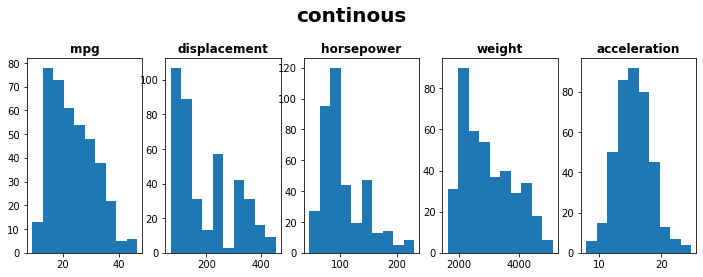

In [139]:
kind = 'continous'
ctype_plotter.plot(data=df, kind=kind);
plt.savefig(f'../reports/{kind}.jpg')

All the variables except acceleration (which seems to be normally distributed) are skewed right i.e. bulk of the data is distributed in one place (low values) and there are some (few) values which skew away to highly positive ones. Options:

- BoxCoxTransformation



#### Ordinal

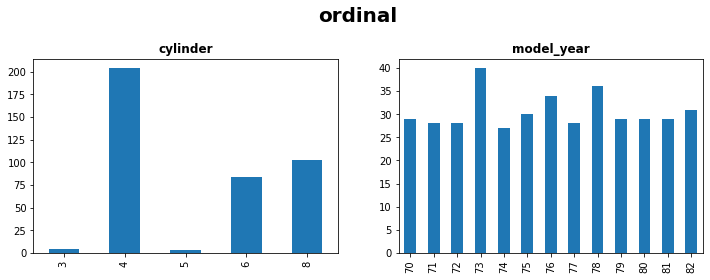

In [137]:
kind = 'ordinal'
ctype_plotter.plot(data=df, kind=kind);
plt.savefig(f'../reports/{kind}.jpg')

#### Nominal

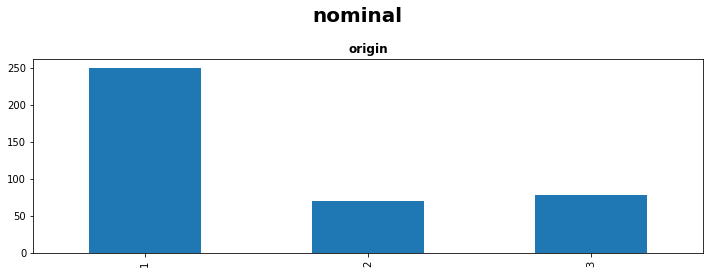

In [138]:
kind = 'nominal'
ctype_plotter.plot(data=df, kind=kind);
plt.savefig(f'../reports/{kind}.jpg')

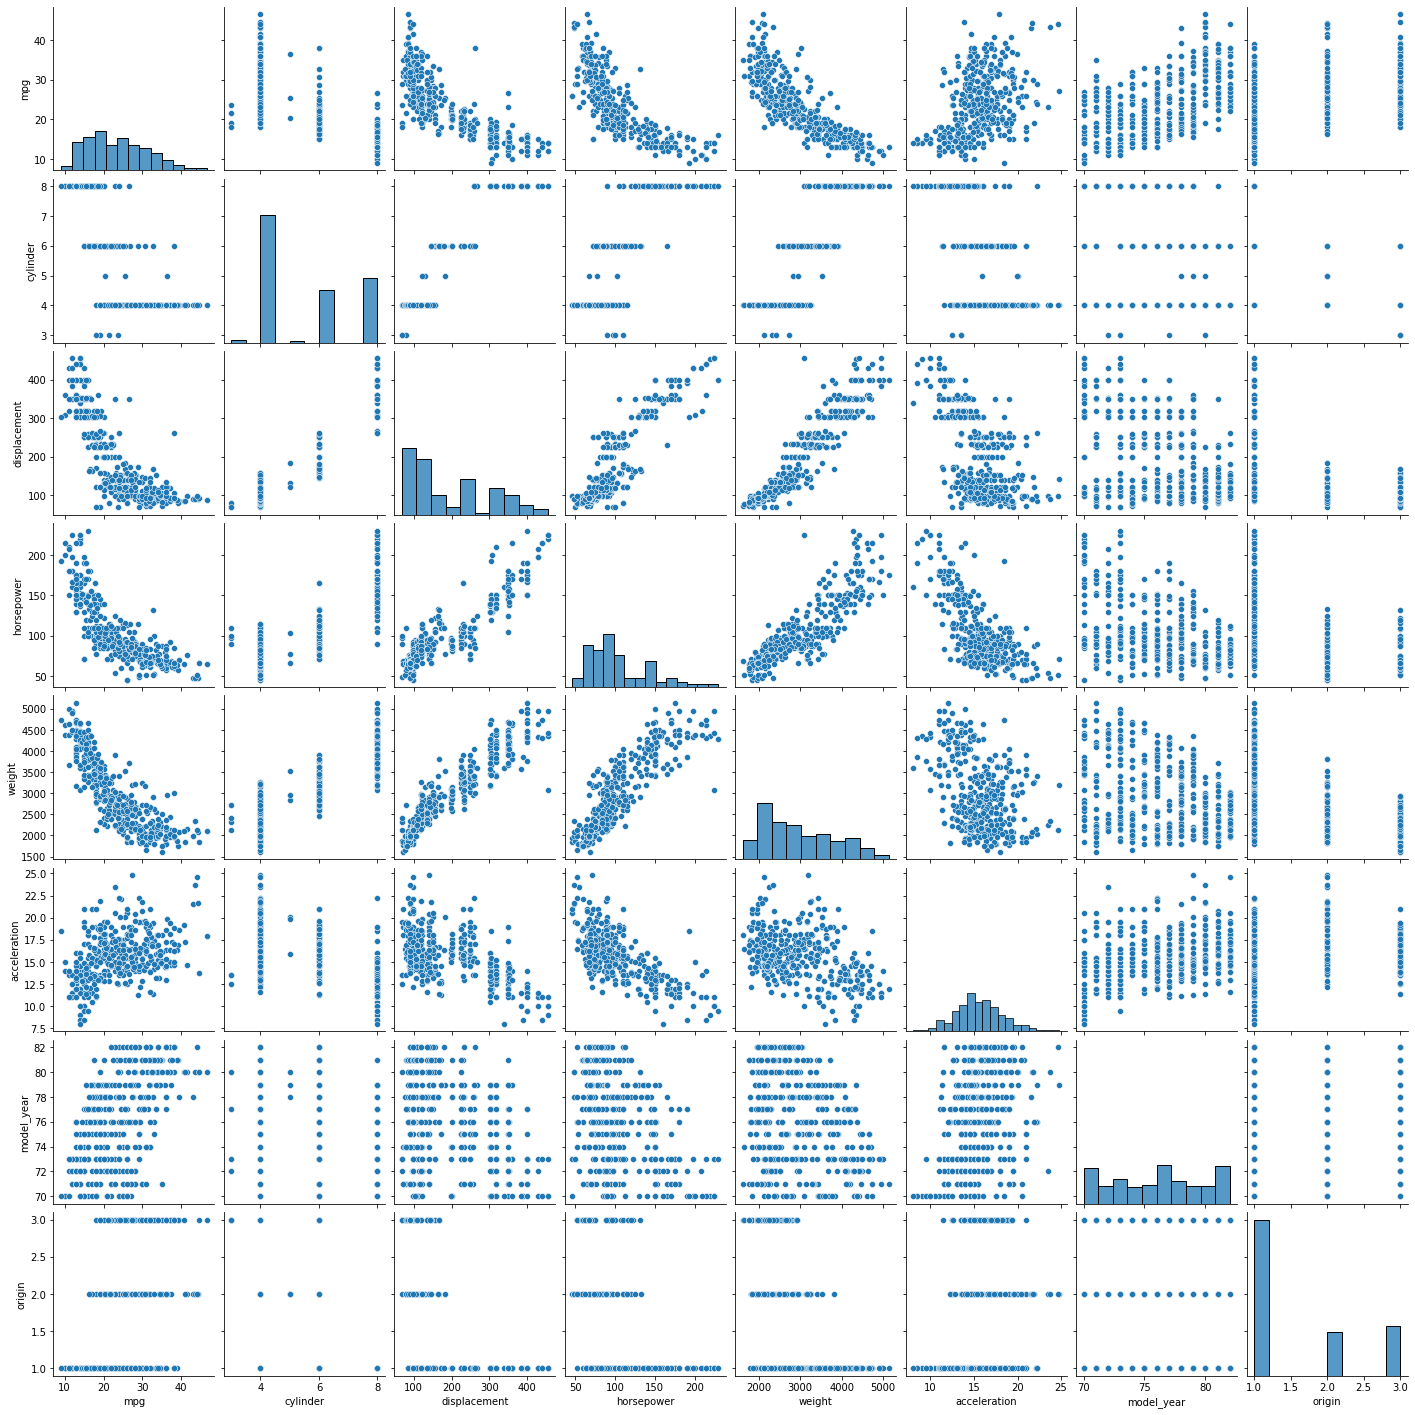

In [61]:
sns.pairplot(data=df)
plt.savefig('../reports/pairplot.jpg')

### Correlation Matrix

In [140]:
corr_mat = df.corr()
corr_mat['mpg'].sort_values(ascending=True)

weight         -0.831741
displacement   -0.804203
horsepower     -0.778427
cylinder       -0.775396
acceleration    0.420289
origin          0.563450
model_year      0.579267
mpg             1.000000
Name: mpg, dtype: float64

Seeing above data it might be better to find higher degree correlation rather than 1-degree correlation. Could be done by fitting a higher degree polynomial and finding the $R^2$ value

### Correlation of feature engineered variables

1. displacement on horsepower
2. weight on cylinder
3. acceleration on horsepower
4. acceleration on cylinder


In [154]:
import functools

In [187]:
on_pairs = [
    ('displacement', 'horsepower'),
    ('weight', 'cylinder'),
    ('acceleration', 'horsepower'),
    ('acceleration', 'cylinder')
]


feature_cols = []
for col1, col2 in on_pairs:
    feature_name = f'{col1}_on_{col2}'
    df[feature_name] = df[col1]/df[col2]

    feature_cols.append(feature_name)

orig_cols = functools.reduce(lambda c1, c2: tuple(set(c1+c2)), on_pairs)

corr_mat = df[['mpg', *orig_cols, *feature_cols]].corr()
corr_mat['mpg']

mpg                           1.000000
weight                       -0.831741
displacement                 -0.804203
horsepower                   -0.778427
cylinder                     -0.775396
acceleration                  0.420289
displacement_on_horsepower   -0.572176
weight_on_cylinder           -0.020778
acceleration_on_horsepower    0.710556
acceleration_on_cylinder      0.732133
Name: mpg, dtype: float64

In [188]:
df.drop(feature_cols, axis=1, inplace=True)

Doesn't seem much useful to be honest. Let us try some polynomial features (degree 2)



In [189]:
orig_cols = ['displacement', 'horsepower', 'weight', 'acceleration']

feature_cols = []
degrees = [2]
for col in cols:
    for deg in degrees:
        feature_name = f'{col}_deg{deg}'
        df[feature_name] = df[col]**deg
        feature_cols.append(feature_name)

corr_mat = df[['mpg', *orig_cols, *feature_cols]].corr()
corr_mat['mpg']

mpg                  1.000000
displacement        -0.804203
horsepower          -0.778427
weight              -0.831741
acceleration         0.420289
displacement_deg2   -0.750854
horsepower_deg2     -0.712297
weight_deg2         -0.805849
acceleration_deg2    0.400170
Name: mpg, dtype: float64

In [190]:
df.drop(feature_cols, axis=1, inplace=True)

## Basic Imputation

The **horsepower** variable was missing.

In [195]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

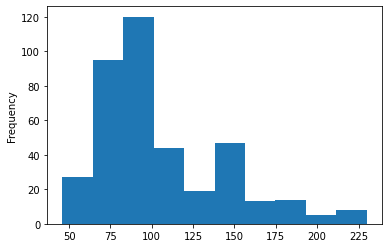

In [177]:
df['horsepower'].plot(kind='hist')

In [202]:
imputers = {}
imputers['median'] = SimpleImputer(strategy='median')
imputers['mean'] = SimpleImputer(strategy='mean')
imputers['iterative'] = IterativeImputer(random_state=42)

is_na = df['horsepower'].isna().to_numpy()
col_idx = df.columns.get_loc('horsepower')
imputed_values = {}

for name, imputer in imputers.items():
    imputed_values[name] = imputer.fit(df).transform(df)[is_na, col_idx]

imputed_values

{'iterative': array([60.04381068, 94.934306  , 56.38375329, 98.41671091, 75.53731594,
        74.29657277]),
 'mean': array([104.46938776, 104.46938776, 104.46938776, 104.46938776,
        104.46938776, 104.46938776]),
 'median': array([93.5, 93.5, 93.5, 93.5, 93.5, 93.5])}

In [203]:
imputed_values = pd.DataFrame(imputed_values)
imputed_values

,median,mean,iterative
0,93.5,104.469388,60.043811
1,93.5,104.469388,94.934306
2,93.5,104.469388,56.383753
3,93.5,104.469388,98.416711
4,93.5,104.469388,75.537316
5,93.5,104.469388,74.296573
